In [1]:
library(cowplot)
library(tidyverse)

theme_set(theme_cowplot())


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


# Subject data

In [2]:
evecs <- read_delim('bcac_maf0.05_ld0.1.eigenvec', delim = ' ', col_names = F) %>%
    rename(subject_ID = X1, sample_ID = X2) %>%
    rename_at(vars(paste0('X', 3:22)), ~ paste0('PC', 1:20))
subject_info <- read_tsv('PhenotypeFiles/phs001265.v1.pht006340.v1.p1.c8.OncoArray_DRIVE_Subject_Phenotypes.GRU.txt', 
                   comment = '#', col_types = 'iccciccdiii') %>%
    inner_join(evecs, by = 'subject_ID')

Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_character()
)
See spec(...) for full column specifications.


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

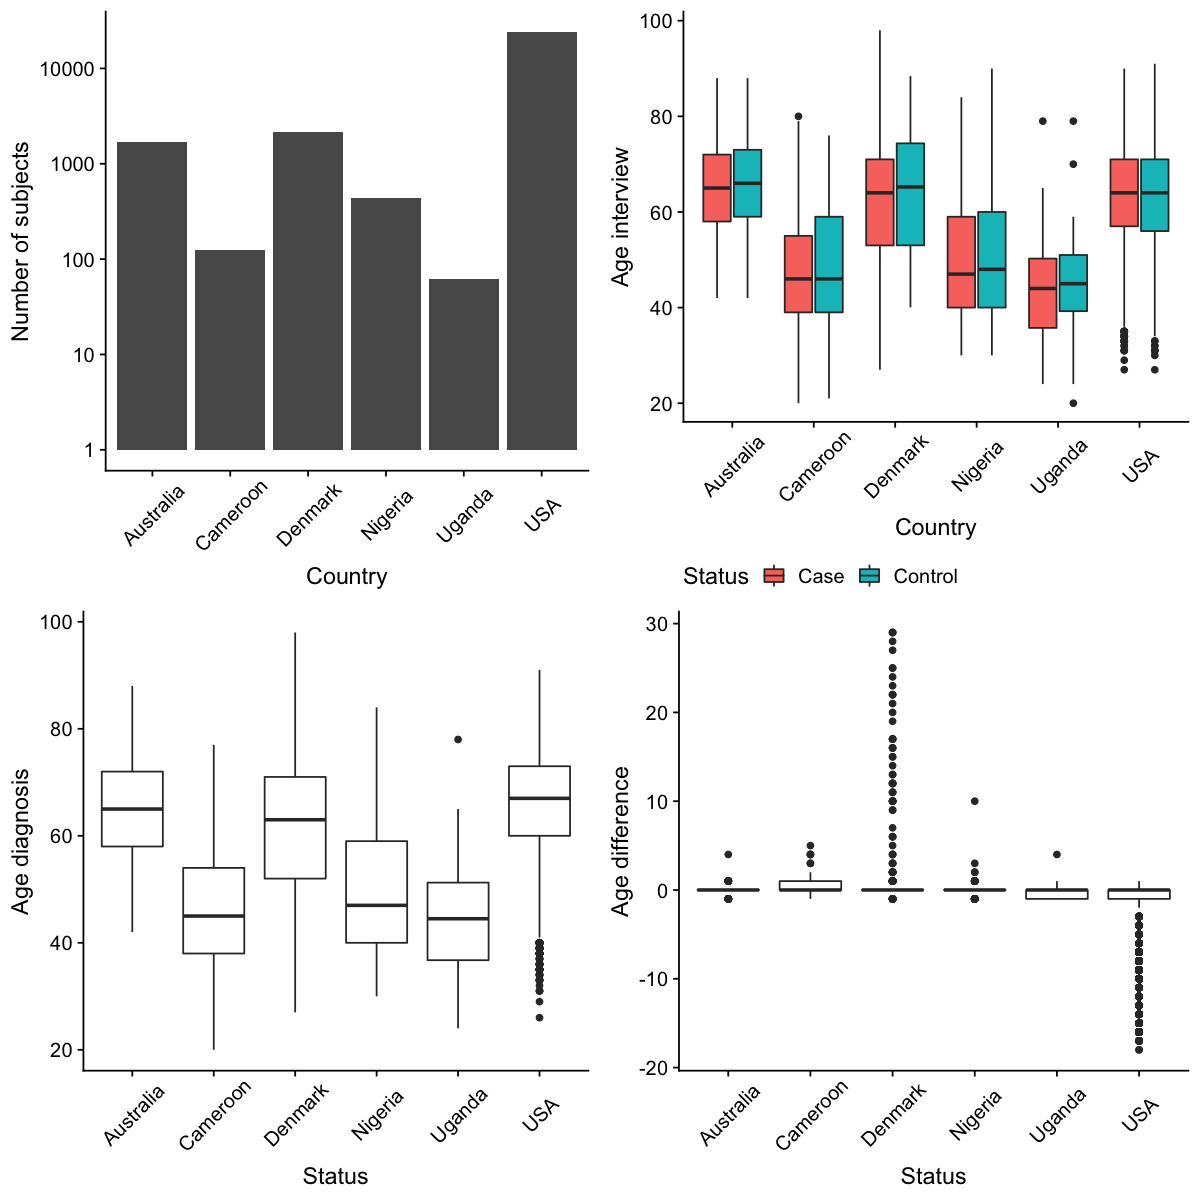

In [3]:
options(repr.plot.width=10, repr.plot.height=10)
study <- ggplot(subject_info, aes(study_country)) +
    geom_histogram(stat="count") +
    scale_y_log10() +
    labs(x = 'Country', y = 'Number of subjects') +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.6))

age <- ggplot(subject_info, 
              aes(x = study_country, 
                  y = age_int, fill = ifelse(status == 0, 'Control', 'Case'))) +
    geom_boxplot() +
    labs(x = 'Country', y = 'Age interview', fill = 'Status') +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.6),
          legend.position = 'bottom')

age_diag <- filter(subject_info, status == 1 & age_diag_index < 777) %>%
    ggplot(aes(x = study_country, y = age_diag_index)) +
        geom_boxplot() +
        labs(x = 'Status', y = 'Age diagnosis') +
        theme(axis.text.x = element_text(angle = 45, vjust = 0.6))

age_diff <- filter(subject_info, status == 1 & age_diag_index < 777) %>%
    ggplot(aes(x = study_country, y = (age_int - age_diag_index))) +
        geom_boxplot() +
        labs(x = 'Status', y = 'Age difference') +
        theme(axis.text.x = element_text(angle = 45, vjust = 0.6))

plot_grid(study, age, age_diag, age_diff)

Observations:

- 60% of the cases come from USA.

- Studies from CIDR are younger (~40 yrs) than others (~60 yrs). Sporadic vs familiar? Higher incidence of BC in those populations?

- How can the age difference be negative in USA?

In [4]:
sample_info <- read_tsv('PhenotypeFiles/phs001265.v1.pht006341.v1.p1.c8.OncoArray_DRIVE_Sample_Attributes.GRU.txt',
         comment = '#', col_types = 'iicccic') %>%
    mutate(is_tumor = ifelse(is_tumor == 'Y', 'Tumor', 'Non-tumor'),
           histological_type = ifelse(histological_type == 777, -1, histological_type)) %>%
    inner_join(evecs, by = "sample_ID")

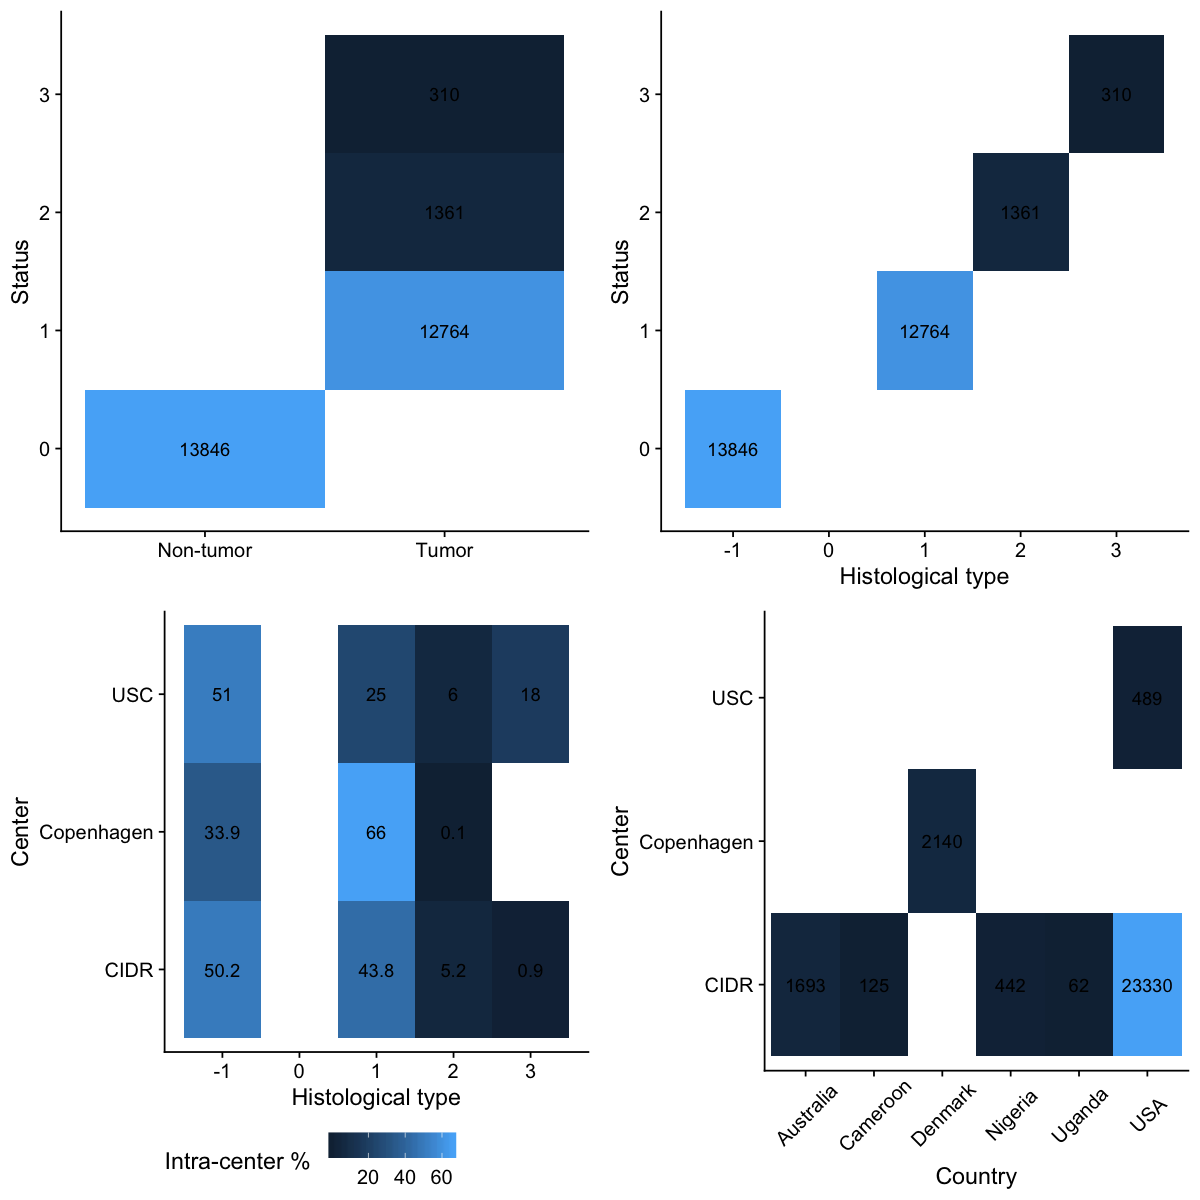

In [5]:
options(repr.plot.width=10, repr.plot.height=10)
sanity <- inner_join(sample_info, subject_info, 
                     by = c("sample_ID", "subject_ID", "PC1", "PC2", "PC3", "PC4", "PC5", 
                            "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", 
                            "PC14", "PC15", "PC16", "PC17", "PC18", "PC19", "PC20"))
is_tumor <- group_by(sanity, status, is_tumor) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = is_tumor, y = status, fill = n, label = n)) +
        geom_tile() +
        geom_text() +
        labs(x = '', y = 'Status') +
        theme(legend.position = 'none')

tissue_type <- group_by(sanity, status, histological_type) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = histological_type, y = status, fill = n, label = n)) +
        geom_tile() +
        geom_text() +
        labs(x = 'Histological type', y = 'Status') +
        theme(legend.position = 'none')

center <- group_by(sanity, genotyping_center, histological_type) %>%
    summarize(n = n()) %>%
    ungroup %>%
    group_by(genotyping_center) %>%
    mutate(n = format(100 * n / sum(n), digits = 1) %>% as.numeric) %>%
    ggplot(aes(x = histological_type, y = genotyping_center, fill = n, label = n)) +
        geom_tile() +
        geom_text() +
        labs(x = 'Histological type', y = 'Center', fill = 'Intra-center %') +
        theme(legend.position = 'bottom')

country_center <- group_by(sanity, genotyping_center, study_country) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = study_country, y = genotyping_center, fill = n, label = n)) +
        geom_tile() +
        geom_text() +
        labs(x = 'Country', y = 'Center') +
        theme(legend.position = 'none') +
        theme(axis.text.x = element_text(angle = 45, vjust = 0.6))

plot_grid(is_tumor, tissue_type, center, country_center)

# Population structure

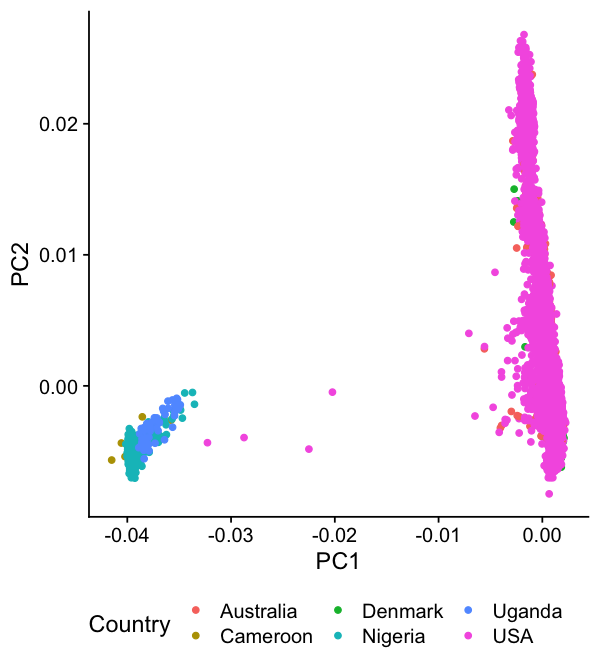

In [6]:
options(repr.plot.width=5, repr.plot.height=5.5)
ggplot(subject_info, aes(PC1, PC2, color = study_country)) +
    geom_point() +
    labs(color = 'Country') +
    theme(legend.position = 'bottom')

## Genomic inflation

In [7]:
snp_test <- read_tsv('univariate.pc_corrected.tsv', col_types = 'icdccdddd')

Warning message:
“Removed 275341 rows containing missing values (geom_point).”

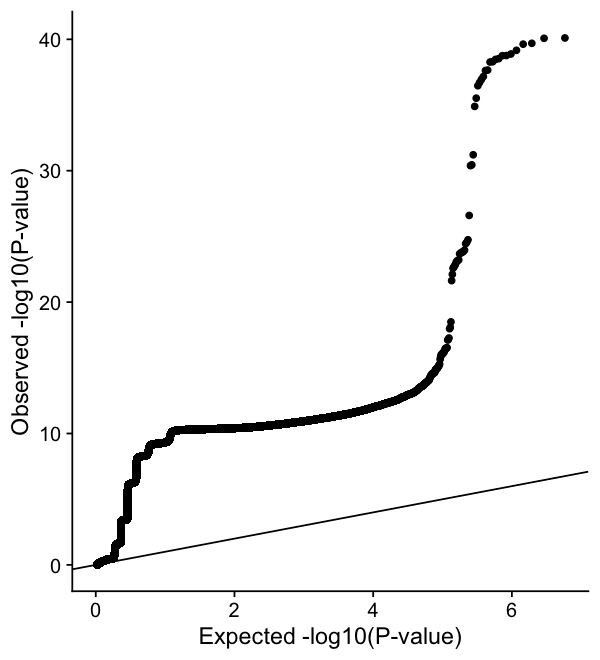

In [18]:
snp_test %>%
    arrange(P) %>%
    mutate(n = (1:n()) / n() ) %>%
    ggplot(aes(-log10(n), -log10(P))) +
        geom_point() +
        geom_abline() +
        labs(x = 'Expected -log10(P-value)', y = 'Observed -log10(P-value)')